In [21]:
%load_ext jupyter_black

import notebooks_path

notebooks_path.include_packages()
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx

from vit import dataloader, util, model, train

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [2]:
batch_size = 8

In [3]:
train_dataloader = dataloader.get_train_dataloader(batch_size)
test_datalodeer = dataloader.get_test_dataloader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image = next(iter(test_datalodeer))

In [5]:
jax_image = jnp.array(image[0][0].numpy())
print(jax_image.shape)

(3, 32, 32)


In [6]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

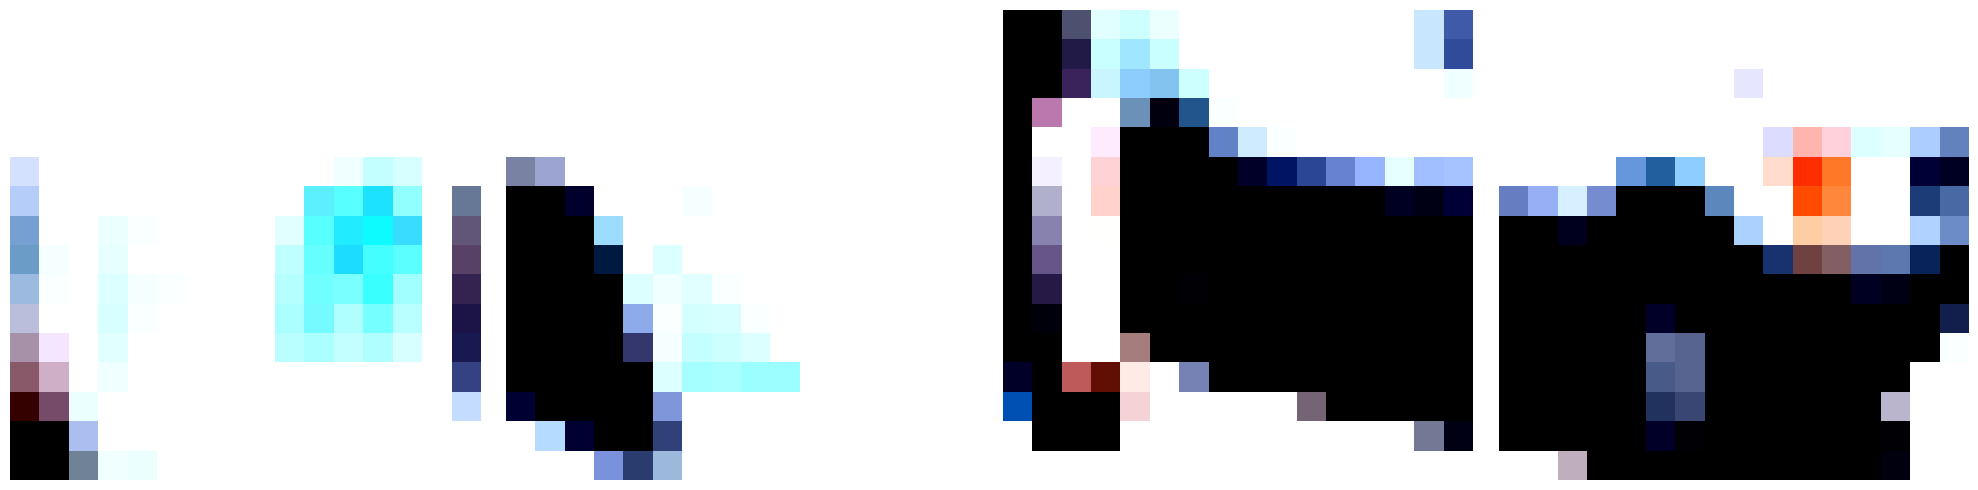

In [7]:
util.plot_patches(patches)

In [12]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

In [16]:
# Hyperparameters
lr = 0.0001
dropout_rate = 0.1
beta1 = 0.9
beta2 = 0.999
batch_size = 64
patch_size = 4
num_patches = 64
num_steps = 100000
image_size = (32, 32, 3)
embedding_dim = 512
hidden_dim = 256
num_heads = 8
num_layers = 6
height, width, channels = image_size
num_classes = 10

In [22]:
key = jr.PRNGKey(2003)

model = model.VisionTransformer(
    embedding_dim=embedding_dim,
    channels=channels,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    patch_size=patch_size,
    num_patches=num_patches,
    num_classes=num_classes,
    key=key,
)

optimizer = optax.adamw(
    learning_rate=lr,
    b1=beta1,
    b2=beta2,
)

state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

model, state, losses = train(model, optimizer, state, trainloader, num_steps, key=key)

NameError: name 'channels' is not defined